# Project: Adversarial BayesFlow

# Experiment 1: MVN means
**Task:** Learn means of a 5-variate Gaussian with unit variance.

In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats

from tqdm.notebook import tqdm

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.exceptions import ConfigurationError
from bayesflow.applications.priors import GaussianMeanPrior, TPrior, GaussianMeanCovPrior
from bayesflow.applications.simulators import GaussianMeanSimulator, MultivariateTSimulator, GaussianMeanCovSimulator

from abf_functions import *

FILEFORMAT = 'png'
RERUN_GRID_EXPERIMENT = False

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)

2021-10-17 17:54:33.856284: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


## Define minimalistic BayesFlow

In [5]:
D = 5
S = 5

#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=S,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

2021-10-17 17:54:36.702270: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path=f'export_ckpt/mmd/means_{D}D_S{S}',
                      max_to_keep = 1
                     )

Networks loaded from export_ckpt/mmd/means_5D_S5/ckpt-50


## Converge BayesFlow

In [7]:
# losses = trainer.train_rounds(epochs=10, rounds=10, sim_per_round=10000, batch_size=128, n_obs=100)

## Adversarial Tasks

In [8]:
# Hypersetup for all tasks
D = 5

In [9]:
def calculate_analytic_posterior(prior, simulator, x):
    n_sim, n_obs, D = x.shape
    
    # Set up variables
    x_bar = np.mean(x, axis=1)                 # empirical mean
    sigma_0 = np.eye(D) * prior.mu_scale       # mu prior covariance
    sigma_0_inv = np.linalg.inv(sigma_0)       # inverse mu prior covariance
    mu_0 = np.ones((D, 1)) * prior.mu_mean     # mu prior mean
    sigma = simulator.sigma                    # likelihood covariance
    sigma_inv = np.linalg.inv(sigma)           # inverse likelihood covariance
    
    mu_posterior_covariance = np.stack([np.linalg.inv(sigma_0_inv + n_obs*sigma_inv)] * n_sim)
    
    mu_posterior_mean = mu_posterior_covariance @ (sigma_0_inv @ mu_0 + n_obs * (sigma_inv @ x_bar[..., np.newaxis]))   
    mu_posterior_mean = mu_posterior_mean.reshape(n_sim, D)

    return mu_posterior_mean, mu_posterior_covariance

In [10]:
def adversarial_diagnostics(trainer, generative_model, theta=None, x=None, 
                            print_plots=False, filename=None):
    theta, x = generative_model(200, 100) if theta is None and x is None else (theta, x)
    param_samples = trainer.network.sample(x, n_samples=200)
    param_means = param_samples.mean(axis=0)
    
    # true parameters
    #print("BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas")
    #true_vs_estimated(theta, param_means, [r'$\mu_%i$'%i for i in range(1, 5+1)], figsize=(20,4))
    
    # analytic posteriors
    print("\n\nBayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means")
    prior = trainer.generative_model.prior.__self__
    simulator = trainer.generative_model.simulator
    posterior_means, posterior_covariances = calculate_analytic_posterior(prior, simulator, x)
    posterior_variances = posterior_covariances.diagonal(axis1=1, axis2=2)
    
    true_vs_estimated(posterior_means, param_means, [r'$\mu_%i$'%i for i in range(1, 5+1)], figsize=(20,4),
                          filename=f"{filename}_true_analytic.{FILEFORMAT}")
    
    #print("\n\nAnalytic posterior means (x) vs. true thetas (y)")
    #true_vs_estimated(posterior_means, theta, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

    if print_plots:
        print('\n\nSummary network response for one batch')
        s = np.array(trainer.network.summary_net(x))
        sns.pairplot(pd.DataFrame(s, columns=[r'$s_%i$'%i for i in range(1, s.shape[1]+1)]), kind="kde")
        
        if filename is not None:
            plt.savefig(f"{filename}_summary_response.{FILEFORMAT}")

### (A0) Baseline



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


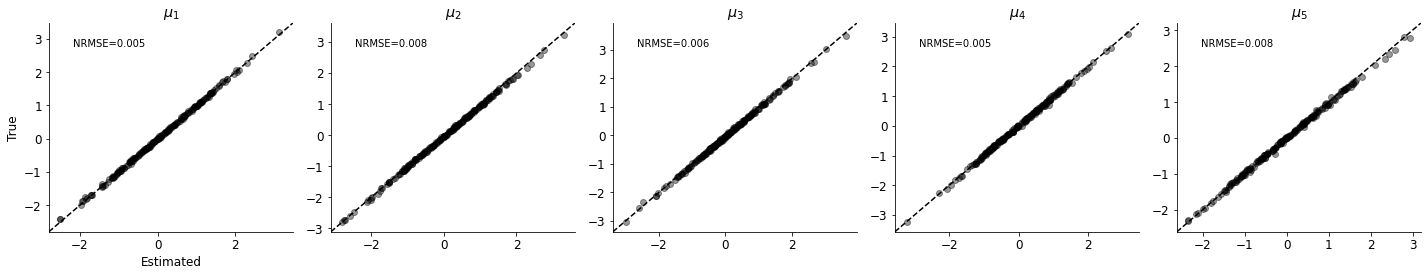

In [11]:
prior_A0 = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A0 = GaussianMeanSimulator(D=D)
generative_model_A0 = GenerativeModel(prior_A0, simulator_A0)
theta_A0, x_A0 = generative_model_A0(200,100)

adversarial_diagnostics(trainer, generative_model_A0, 
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_baseline")

## (A1) Wrong Prior
The prior over the multivariate Gaussian's means is Gaussian: $\mu\sim\mathcal{N}(\mu_\mu, \sigma_\mu)$

During training, the mean's prior was $\mu\sim\mathcal{N}(0, 1)$. This adversarial tasks varies the prior in three steps for the evaluation:

- **(A1)-1** Wrong (free) prior location: $\mu\sim\mathcal{N}(\mu_\mu, 1)$
- **(A1)-2** Wrong (free) prior scale: $\mu\sim\mathcal{N}(0, \sigma_\mu)$
- **(A1)-3** Wrong (free) prior location and scale: $\mu\sim\mathcal{N}(\mu_\mu, \sigma_\mu)$

### (A1)-a Wrong prior location

In [12]:
# Posterior wrong, model misspecified



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


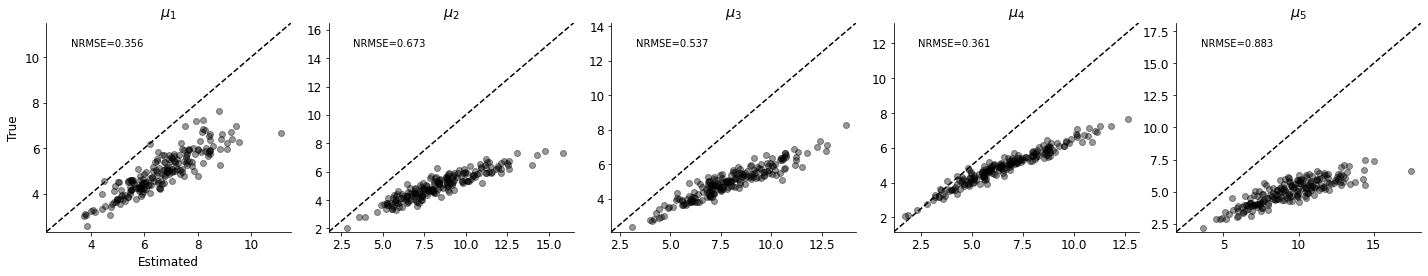

In [13]:
prior_A1a = GaussianMeanPrior(D=D, mu_mean=5, mu_scale=1)
simulator_A1a = GaussianMeanSimulator(D=D)
generative_model_A1a = GenerativeModel(prior_A1a, simulator_A1a)
theta_A1a, x_A1a = generative_model_A1a(200,100)

adversarial_diagnostics(trainer, generative_model_A1a, 
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_prior_location")

### (A1)-b Wrong prior scale



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


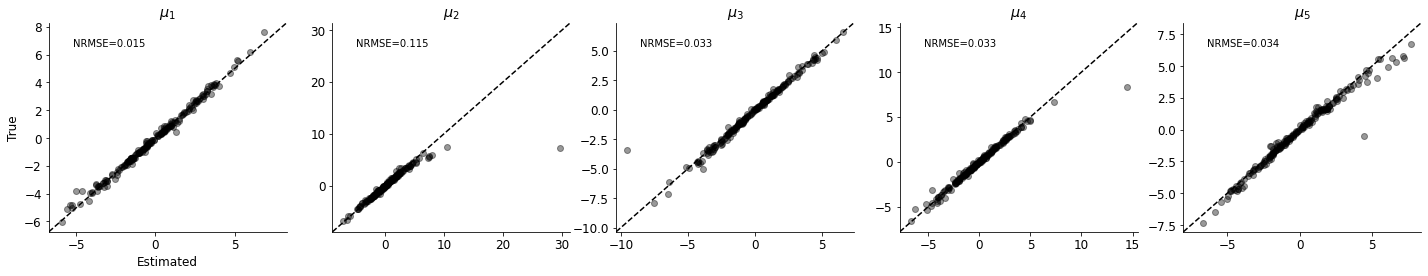

In [14]:
prior_A1b = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=2.5)
simulator_A1b = GaussianMeanSimulator(D=D)
generative_model_A1b = GenerativeModel(prior_A1b, simulator_A1b)

theta_A1b, x_A1b = generative_model_A1b(200,100)

adversarial_diagnostics(trainer, generative_model_A1b,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_prior_scale")

### (A1)-c Wrong prior location and scale



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


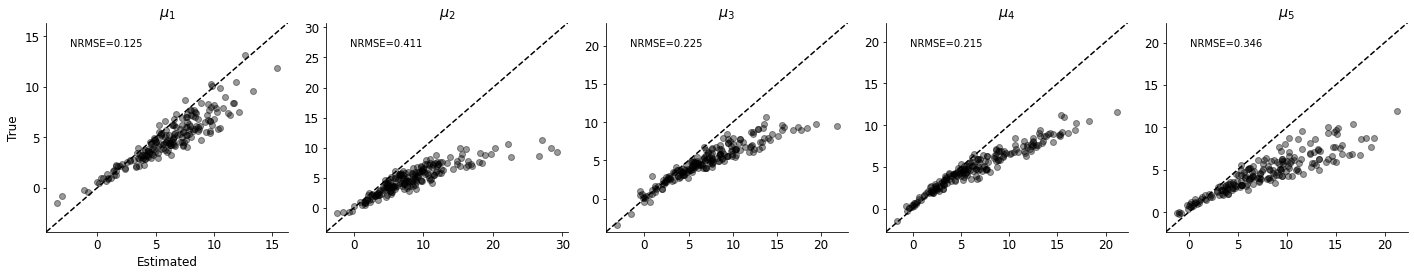

In [15]:
prior_A1c = GaussianMeanPrior(D=D, mu_mean=5, mu_scale=2.5)
simulator_A1c = GaussianMeanSimulator(D=D)
generative_model_A1c = GenerativeModel(prior_A1c, simulator_A1c)
theta_A1c, x_A1c = generative_model_A1c(200,100)

adversarial_diagnostics(trainer, generative_model_A1c,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_prior_location_scale")

## (A2) Wrong Likelihood

### (A2)-a Wrong fixed parameter in likelihood

$\boldsymbol{x}^{(i)}\sim \mathcal{N}(\boldsymbol{\mu}^{(i)}, 10\cdot\mathbb{I})$



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


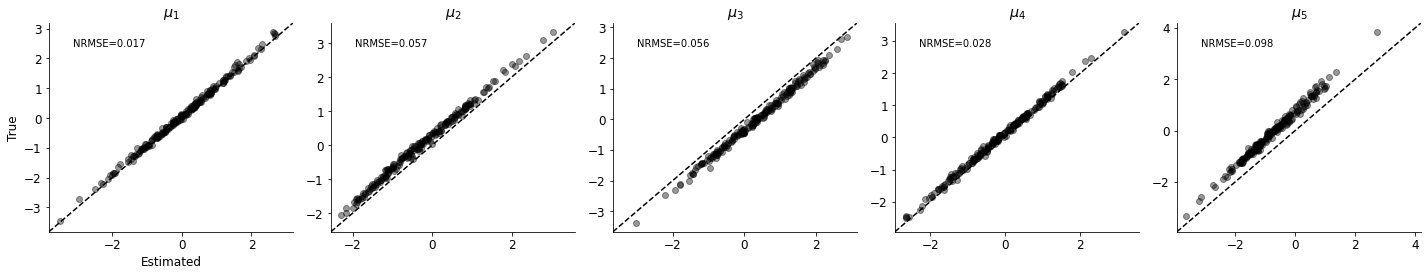

In [16]:
prior_A2a = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A2a = GaussianMeanSimulator(D=D, s = 10.0)
generative_model_A2a = GenerativeModel(prior_A2a, simulator_A2a)
theta_A2a, x_A2a = generative_model_A2a(200,100)

adversarial_diagnostics(trainer, generative_model_A2a,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_likelihood_scale")

### (A2)-b Wrong likelihood function



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


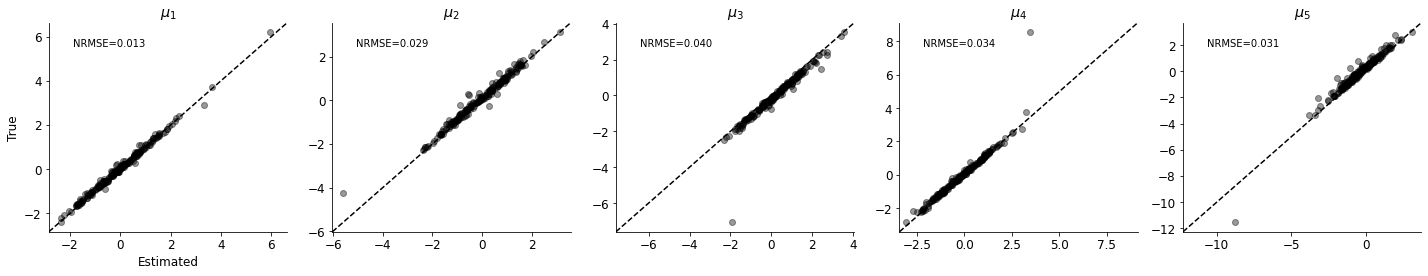

In [17]:
prior_A2b = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A2b = MultivariateTSimulator(df=2)

means_A2b = prior_A2b(200)
sigma_A2b = np.ones_like(means_A2b)
theta_A2b = np.concatenate((means_A2b, sigma_A2b), axis=1)
x_A2b = simulator_A2b(theta_A2b, 100)


adversarial_diagnostics(trainer, generative_model=None, theta=theta_A2b, x=x_A2b,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_likelihood_t")

## (A3) Noise
$\mathbf{x}_n = \mathbf{x}_n + \xi$

In [18]:
def normalize(x):
    n_sim, n_obs, data_dim = x.shape
    s = np.std(x, axis=1)
    s_reshaped = s.reshape(n_sim, 1, data_dim).repeat(n_obs, axis=1)
    x_normalized = np.divide(x, s_reshaped)
    return x_normalized

### Pink noise

In this scenario, the contamination $\xi$ is *pink noise* (aka $\frac{1}{f}$ noise) and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim \frac{1}{f}$

#### Posterior correct, model misspecified



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


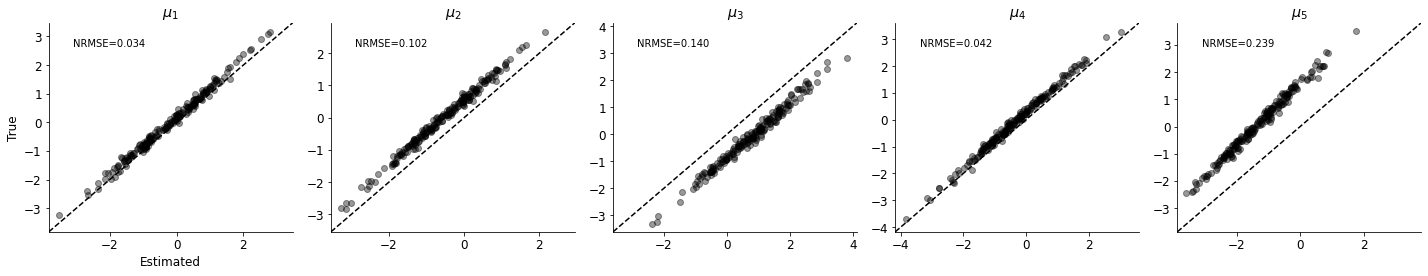

In [20]:
import colorednoise as cn

prior_A3a = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A3a = GaussianMeanSimulator(D=D)

generative_model_A3a = GenerativeModel(prior_A3a, simulator_A3a)
theta_A3a, x_A3a = generative_model_A3a(200, 100)

lamda = 5.0  # contribution of contamination xi 

xi = cn.powerlaw_psd_gaussian(exponent=1, size=x_A3a.shape)

x_o_A3a = x_A3a + lamda * normalize(xi)

adversarial_diagnostics(trainer, generative_model=None, theta=theta_A3a, x=x_o_A3a,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_noise_pink")

### t Noise
In this scenario, the contamination $\xi$ is $t-$distributed and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim t_2(0, \mathbb{I})$



BayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means


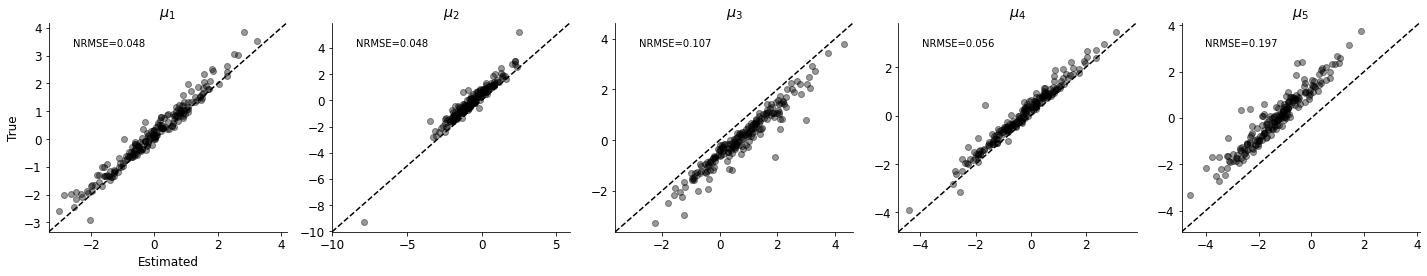

In [21]:
prior_A3b = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator_A3b = GaussianMeanSimulator(D=D)
generative_model_A3b = GenerativeModel(prior_A3b, simulator_A3b)

theta_A3b, x_A3b = generative_model_A3b(200, 100)

n_sim, n_obs, data_dim = x_A3b.shape


lamda = 2.5
xi_theta = np.concatenate((np.zeros((n_sim, data_dim)), np.ones((n_sim, data_dim))), axis=1)
xi_simulator = MultivariateTSimulator(df=2)
xi = xi_simulator(xi_theta, n_obs)

x_o_A3b = x_A3b + lamda * xi

adversarial_diagnostics(trainer, generative_model=None, theta=theta_A3b, x=x_o_A3b,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_S{S}_noise_t")

# Summary space: MD and MMD plots

In [22]:
def MMD_analysis(x_star, X_o):
    z_psi = np.array(trainer.network.summary_net(x_star))
    MMD = np.zeros(len(X_o))

    for i, x_o in enumerate(X_o):
        s_o = np.array(trainer.network.summary_net(x_o))
        MMD[i] = float(maximum_mean_discrepancy(s_o, z_psi, unbiased=True))

    return MMD

In [23]:
def plot_mvn_MMD(MMD, alphas, task_name, x_label, baseline_param, ylim=0, xticks=None):
    plt.figure(figsize=(12, 6))
    if baseline_param is not None:
        baseline_idx = np.where(alphas==baseline_param)
        plt.axhline(y=MMD[baseline_idx], color="gray", ls="--")

    plt.plot(alphas, MMD, marker='s')

    plt.xlabel(x_label)
    if xticks is not None:
        plt.xticks(xticks)
    plt.ylabel("MMD")
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f"plots/abf_mvn_means_S{S}_mmd_summary_{task_name}.{FILEFORMAT}")
    plt.show()

## MM Pairplot: Baseline, prior, simulator, noise

In [ ]:
X = [x_A1c, x_A2a, x_o_A3a, x_A0]
TASK_NAMES = ['prior', 'simulator', 'noise', 'no MM']

DF = (pd.DataFrame(np.array(trainer.network.summary_net(x)), 
                     columns=[r'$s_{%i}$'%i for i in range(1, S+1)]) for x in X)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['MM', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="MM", palette=['red', 'orange', 'green', 'blue'], height=3)

g.map_upper(plt.scatter, alpha=0.2)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.70)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=24)
plt.setp(g._legend.get_texts(), fontsize=20)

plt.savefig(f"plots/abf_mvn_means_S{S}_pairplot_MVN.{FILEFORMAT}")

## $\widehat{MMD}^2_u$ w.r.t. prior (location and scale factor)

In [29]:
n_loc = 101
n_scale = 101
prior_loc = np.linspace(-5.0, 5.0, num = n_loc)
prior_scale = np.linspace(0.10, 5.90, num = n_scale)

P1, P2 = np.meshgrid(prior_loc, prior_scale)

In [30]:
if RERUN_GRID_EXPERIMENT:
    _, x = trainer._forward_inference(200, 100)
    z_psi = np.array(trainer.network.summary_net(x))

    MMD = np.zeros((n_scale, n_loc))
    for i in tqdm(range(n_scale)):
        for j in range(n_loc):
            p1 = P1[i, j]
            p2 = P2[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=p1, mu_scale=p2)
            simulator = GaussianMeanSimulator(D=D)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)
            s_o = np.array(trainer.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, z_psi, unbiased=True))
    np.save(f"MMD_MVN_S{S}_prior_location101_scale101.npy", MMD)

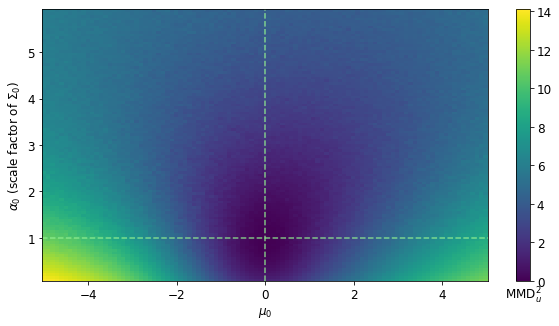

In [31]:
MMD = np.load(f"data/MMD_grid_experiments/MMD_MVN_S{S}_prior_location101_scale101.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(P1, P2, MMD, shading="nearest")
plt.xlabel(r"$\mu_0$")
plt.ylabel(r"$\alpha_0$ (scale factor of $\Sigma_0$)")
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=.80)
plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=.80)
cbar = plt.colorbar()
cbar.ax.set_xlabel(r"MMD$^2_u$")
plt.savefig(f"plots/abf_mvn_means_S{S}_mmd_priorMM.{FILEFORMAT}")

## $\widehat{MMD}^2_u$ w.r.t. likelihood and noise

In [24]:
n_alpha = 101
n_lamda = 101
alpha_list = np.linspace(0.1, 5.0, num = n_alpha)
lamda_list = np.linspace(0.0, 5.0, num = n_lamda)

alpha_grid, lamda_grid = np.meshgrid(alpha_list, lamda_list)

In [25]:
if RERUN_GRID_EXPERIMENT:
    _, x = trainer._forward_inference(200, 100)
    z_psi = np.array(trainer.network.summary_net(x))

    MMD = np.zeros((n_lamda, n_alpha))
    for i in tqdm(range(n_lamda)):
        for j in range(n_alpha):
            alpha = alpha_grid[i, j]
            lamda = lamda_grid[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=0.0, mu_scale=1.0)
            simulator = GaussianMeanSimulator(D=D, s=alpha)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)

            xi = cn.powerlaw_psd_gaussian(exponent=1, size=x.shape)
            xi = normalize(xi)

            x_o = x_o + lamda * xi

            s_o = np.array(trainer.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, z_psi, unbiased=True))
    np.save(f"MMD_MVN_S{S}_likelihood_noise.npy", MMD)

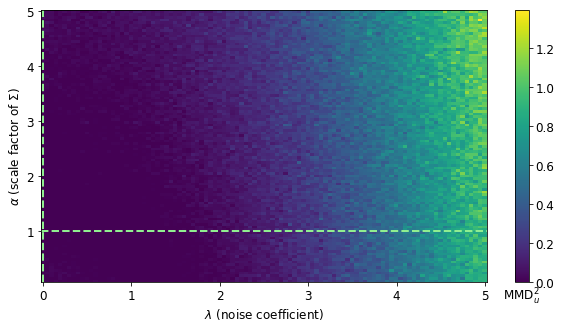

In [27]:
MMD = np.load(f"data/MMD_grid_experiments/MMD_MVN_S{S}_likelihood_noise.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(lamda_list, alpha_list, MMD.T, shading="nearest")

plt.xlabel(r"$\lambda$ (noise coefficient)")
plt.ylabel(r"$\alpha$ (scale factor of $\Sigma$)")

plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)
cbar = plt.colorbar()
cbar.ax.set_xlabel(r"MMD$^2_u$")

plt.savefig(f"plots/abf_mvn_means_S{S}_mmd_likelihood_noise_MM.{FILEFORMAT}")

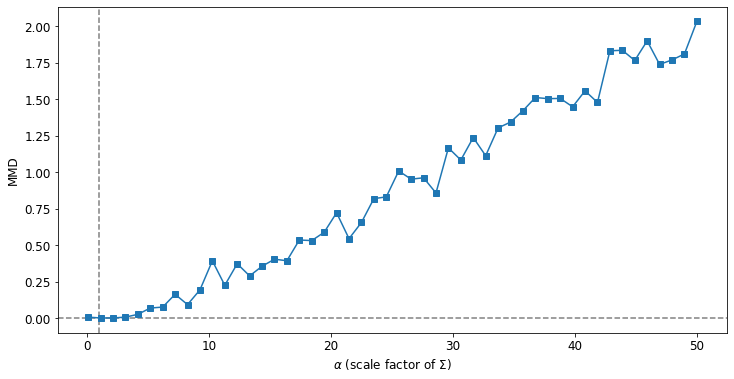

In [28]:
task_name = "likelihood_scale"
x_label = r"$\alpha$ (scale factor of $\Sigma$)"

theta, x = trainer._forward_inference(200, 100)

X_o = []
alphas = np.linspace(0.1, 50, num=50)

for alpha in alphas:
    prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1.0)
    simulator = GaussianMeanSimulator(D=D, s=alpha)
    generative_model = GenerativeModel(prior, simulator)
    _, x_o = generative_model(200, 100)
    X_o.append(x_o)
    
MMD = MMD_analysis(x, X_o)

plt.figure(figsize=(12, 6))
plt.axhline(y=0.0, color="gray", ls="--")
plt.axvline(x=1.0, color="gray", ls="--")
plt.plot(alphas, MMD, marker='s')
plt.xlabel(x_label)
plt.ylabel("MMD")
plt.show()

## MM new pairplot

In [32]:
D = 5
S = 5

#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=S,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer_S5 = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path=f'export_ckpt/mmd/means_{D}D_S{S}',
                      max_to_keep = 1
                     )

Networks loaded from export_ckpt/mmd/means_5D_S5/ckpt-50


In [33]:
D = 5
S = 10

#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=S,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer_S10 = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path=f'export_ckpt/mmd/means_{D}D_S{S}',
                      max_to_keep = 1
                     )

Networks loaded from export_ckpt/mmd/means_5D_S10/ckpt-100


In [34]:
# No MMS
_, x_no_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(200,100)

# Prior MMS
_, x_prior_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=5, mu_scale=2.5), 
    GaussianMeanSimulator(D=D))(200,100)

_, x_simulator_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D, s=10.0))(200,100)

_, x_noise_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(200,100)
x_noise_MMS += 5.0 * normalize(cn.powerlaw_psd_gaussian(exponent=1, size=x_no_MMS.shape))

In [35]:
s_no_MMS = np.array(trainer_S5.network.summary_net(x_no_MMS))
s_prior_MMS = np.array(trainer_S5.network.summary_net(x_prior_MMS))
s_simulator_MMS_S5 = np.array(trainer_S5.network.summary_net(x_simulator_MMS))
s_noise_MMS = np.array(trainer_S5.network.summary_net(x_noise_MMS))

In [36]:
from sklearn.decomposition import PCA

s_simulator_MMS_S10 = np.array(trainer_S10.network.summary_net(x_simulator_MMS))

pca = PCA(n_components=5)
s_simulator_MMS_S10_projections = pca.fit_transform(s_simulator_MMS_S10)

In [38]:
S_DIAG = [s_no_MMS, s_prior_MMS, s_simulator_MMS_S5, s_simulator_MMS_S10_projections, s_noise_MMS]
S_LOWER = [s_no_MMS, s_prior_MMS, s_noise_MMS]
S_UPPER = [s_no_MMS, s_simulator_MMS_S5, s_simulator_MMS_S10_projections]

In [87]:
TASK_NAMES = ['Prior', 'Simulator S5', 'Simulator S10 PCA', 'Noise', 'No MMS']
S_ALL = [s_prior_MMS, s_simulator_MMS_S5, s_simulator_MMS_S10_projections, s_noise_MMS, s_no_MMS]
DF = (pd.DataFrame(s, columns=[r'$s_{%i}$'%i for i in range(1, S+1)]) for s in S_ALL)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['MMS', None]
              ).reset_index(level=0)

In [88]:
def scatter_subset(x, y, hue, mask, **kws):
    sns.scatterplot(x=x[mask], y=y[mask], hue=hue[mask], **kws)

[None, None, None, None, None, None, None, None, None, None]

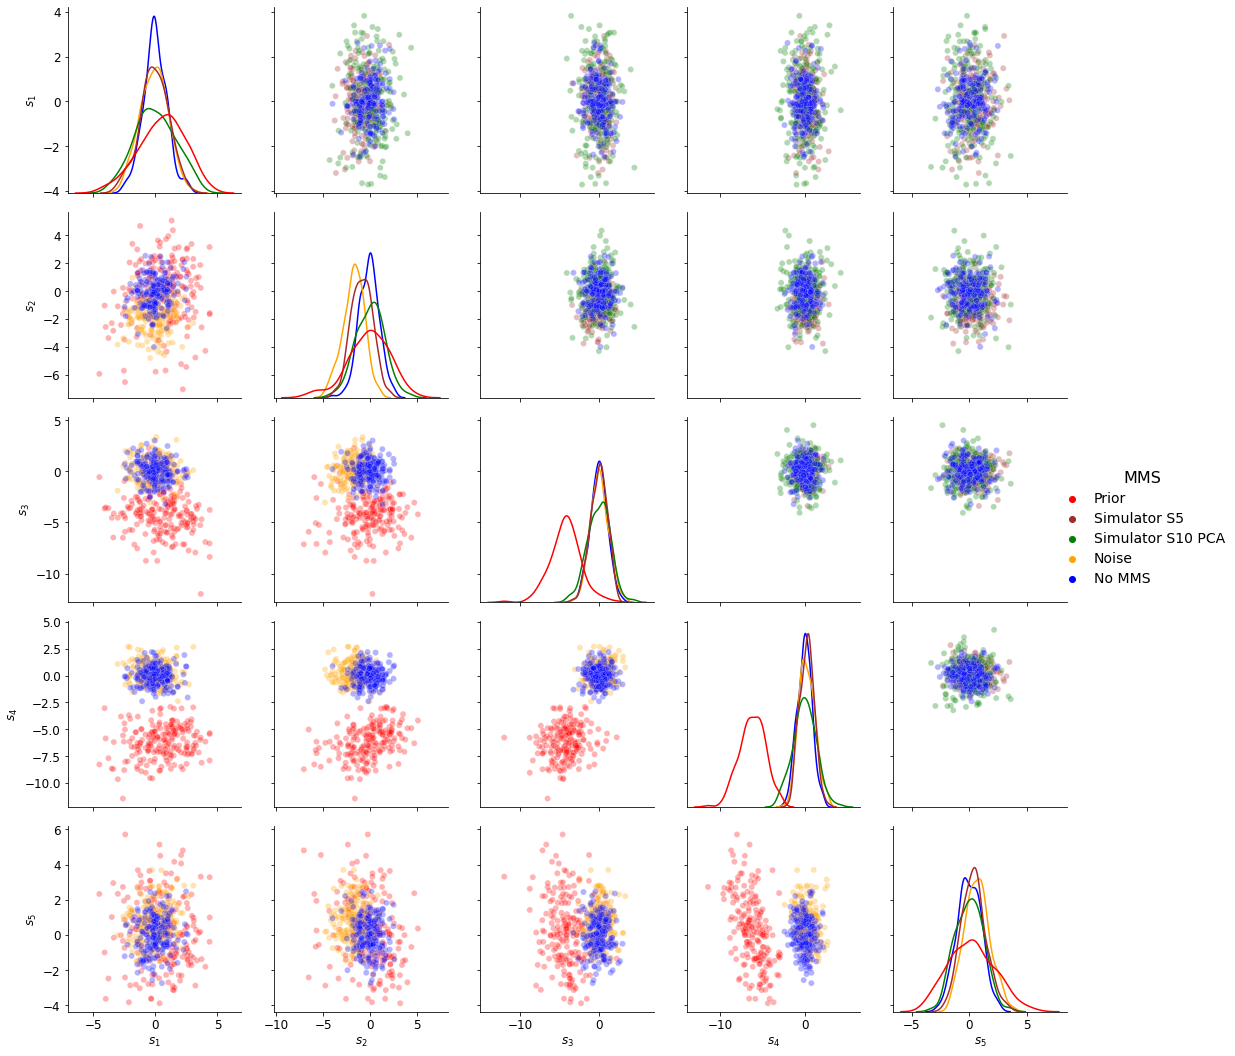

In [91]:
g = sns.PairGrid(df, hue="MMS", height=3, palette=['red', 'brown', 'green', 'orange', 'blue'])

g.map_lower(scatter_subset, mask= 
            (
                (df["MMS"] == 'Prior') |
                (df["MMS"] == 'Noise') |
                (df["MMS"] == 'No MMS')
           ),
            alpha=.30
           )


g.map_upper(scatter_subset, mask= 
            (
                (df["MMS"] == 'Simulator S5') |
                (df["MMS"] == 'Simulator S10 PCA') |
                (df["MMS"] == 'No MMS')
           ), 
            alpha=.30
           )

g.map_diag(sns.kdeplot)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=16)
plt.setp(g._legend.get_texts(), fontsize=14)